In [28]:
# !pip install rioxarray
!pip install "xarray[complete]"

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [29]:
import rioxarray as rx
import pandas as pd
import boto3
import xarray as xr

In [56]:
continentalBox = [("Africa",-20.0, -35.0, 55.0, 40.0)
                    ,("Antartica",-180.0, -90.0, 180.0, -60.0)
                    ,("Asia",25.0, -12.0, 180.0, 75.0)
                    ,("Europe",-25.0, 35.0, 45.0, 75.0)
                    ,("North_America",-180.0, 10.0, -35.0, 75.0)
                    ,("Oceania",100.0, -50.0, 180.0, -10.0)
                    ,("South_America",-90.0, -60.0, -30.0, 15.0)
                    ]
continentalDf = pd.DataFrame(continentalBox
                            ,columns=["continent"
                                      ,"xmin"
                                      ,"ymin"
                                      ,"xmax"
                                      ,"ymax"])

bucketName = "climate-action-datalake"
s3LandingPath = "zone=landing/source=agera5/variable=2mTemperature/"

In [58]:
def listS3Files(bucketName: str
                , path: str
               ):

    objectArr = []
    s3 = boto3.resource("s3")
    s3Bucket = s3.Bucket(bucketName)
    for blob in s3Bucket.objects.filter(Prefix=path):
        objectArr.append(blob)
    return objectArr

def convertKelvinCelsious(k):
    c = k -273.15
    return c

def filesToProcess(s3Files: []
                   , year: int=None
                  ):

    filesToProces = pd.DataFrame(columns=['s3_path', 'file_name'])
    s3Path = []
    fileName = []
    if year:
        for blob in s3Files:
            if str(year) in blob.key:
                file = blob.key
                s3Path.append(file)
                fileName.append(file.split('/')[3].split('.')[0])
    else:
        for blob in s3Files:
            file = blob.key
            s3Path.append(file)
            fileName.append(file.split('/')[3].split('.')[0])
    filesToProces['s3_path'] = s3Path
    filesToProces['file_name'] = fileName
    return filesToProces

def downloadData(bucketName:str
                ,s3Path:str
                ,outputName:str
                 ,s3
                ):
    s3.download_file(bucketName
                 ,s3Path
                 ,outputName)

def cutGeoTiff(continentsDf
               , geoTiff
               ,fileName : str
               ,outputPath : str
              ):
  for index, row in ContinentalDf.iterrows():
        continentName = row['continent']
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']
        _geoTiff = geoTiff.rio.clip_box(xmin, ymin, xmax, ymax)
        _geoTiff.rio.to_raster(f"{outputPath}/{fileName}{continentName}.tiff")

def uploadData(,zone,source,variable):
    
    s3_client.put_object(Bucket=bucket
                     ,Key=f"zone={zone}/source={source}/variable={variable}/"+file_path
                     ,Body=response.content
                    )

In [6]:
s3Files =  listS3Files(bucketName = bucketName
                       ,path = s3LandingPath)

In [10]:
df = filesToProcess( s3Files = s3Files)

In [34]:
df


,s3_path,file_name
0,zone=landing/source=agera5/variable=2mTemperat...,Temperature-Air-2m-Max-24h_C3S-glob-agric_AgER...
1,zone=landing/source=agera5/variable=2mTemperat...,Temperature-Air-2m-Max-24h_C3S-glob-agric_AgER...
2,zone=landing/source=agera5/variable=2mTemperat...,Temperature-Air-2m-Max-24h_C3S-glob-agric_AgER...
3,zone=landing/source=agera5/variable=2mTemperat...,Temperature-Air-2m-Max-24h_C3S-glob-agric_AgER...
4,zone=landing/source=agera5/variable=2mTemperat...,Temperature-Air-2m-Max-24h_C3S-glob-agric_AgER...
...,...,...
48208,zone=landing/source=agera5/variable=2mTemperat...,Temperature-Air-2m-Min-24h_C3S-glob-agric_AgER...
48209,zone=landing/source=agera5/variable=2mTemperat...,Temperature-Air-2m-Min-24h_C3S-glob-agric_AgER...
48210,zone=landing/source=agera5/variable=2mTemperat...,Temperature-Air-2m-Min-24h_C3S-glob-agric_AgER...
48211,zone=landing/source=agera5/variable=2mTemperat...,Temperature-Air-2m-Min-24h_C3S-glob-agric_AgER...


In [61]:
 s3 = boto3.client("s3")
outputPath = "data"
originaExtension = "nc"
downloadFile = outputPath+"/"+df.iloc[0].file_name+"."+originaExtension
downloadData(bucketName = bucketName
             ,s3Path = df.iloc[0].s3_path
             ,outputName = downloadFile
             ,s3 = s3
            )
geoFile= xr.open_dataset(downloadFile)
geoFileC = geoFile.apply(convertKelvinCelsious)
variable = list(geoFileC.keys())[0]
variableValues = geoFileC[variable]
variableValues = variableValues.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
variableValues.rio.write_crs("epsg:4326", inplace=True)
variableValues.rio.to_raster(r"data/dev.tiff")
rxDf = rx.open_rasterio("data/dev.tiff")
cutGeoTiff(continentsDf = continentalDf
               , geoTiff =  rxDf
               ,fileName = df.iloc[0].file_name
               ,outputPath = outputPath
              )

#variableValues = geoFileC["Temperature_Air_2m_Max_24h"]

In [54]:
variable

'Temperature_Air_2m_Max_24h'

In [58]:
file.split('/')[3]

'Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_19790101_final-v1.0.nc'

In [5]:
    s3 = boto3.client("s3")


In [6]:
downloadPath = "data/Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_19790103_final-v1.0.nc"


In [7]:
s3.download_file("climate-action-datalake"
                 ,"zone=landing/source=agera5/variable=2mTemperature/Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_19790103_final-v1.0.nc"
                ,"data/Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_19790103_final-v1.0.nc")

In [9]:
geoFileC = geoFile.apply(convertKelvinCelsious)

In [11]:
variableValues = variableValues.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

In [12]:
variableValues.rio.crs

In [25]:
variableValues.rio.write_crs("epsg:4326", inplace=True)

<xarray.DataArray 'Temperature_Air_2m_Max_24h' (time: 1, lat: 1801, lon: 3600)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-25.303177, -25.302933, -25.304764, ..., -25.302292,
         -25.301697, -25.303513],
        [-25.044754, -25.04486 , -25.044601, ..., -25.04454 ,
         -25.044647, -25.044708],
        [-24.965363, -24.965363, -24.965363, ..., -24.965363,
         -24.965363, -24.965363]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-03
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * lat          (lat) float64 90.0 89.9 89.8 89.7 ... -89.7 -89.8 -89.9 -90.0
    spatial_ref  int64 0

In [33]:
asia = rx.open_rasterio('Asia.tiff')

In [34]:
continent = asia[0]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


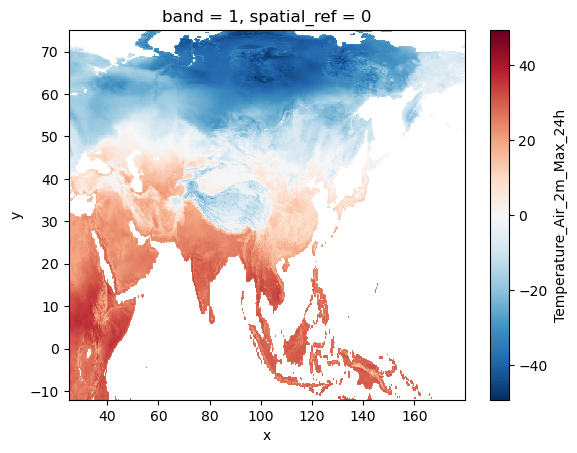

In [36]:
continent.plot()

In [30]:
rxDf.name = "data"
rxDf.to_dataframe().reset_index()

,band,y,x,spatial_ref,data
0,1,90.0,-180.0,0,NaN
1,1,90.0,-179.9,0,NaN
2,1,90.0,-179.8,0,NaN
3,1,90.0,-179.7,0,NaN
4,1,90.0,-179.6,0,NaN
...,...,...,...,...,...
6483595,1,-90.0,179.5,0,-24.965363
6483596,1,-90.0,179.6,0,-24.965363
6483597,1,-90.0,179.7,0,-24.965363
6483598,1,-90.0,179.8,0,-24.965363
